In [ ]:
# DICE SM - PRIM (recovered --> master)

  ## Setup & Initialisation of levers and uncertainties

In [1]:

import time
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
# import statsmodels.api as sm

from sklearn import preprocessing 



In [2]:
from ema_workbench import (perform_experiments, Model, Policy, Scenario, ReplicatorModel, RealParameter, IntegerParameter, TimeSeriesOutcome, ScalarOutcome, ArrayOutcome, Constant, ema_logging, SequentialEvaluator, MultiprocessingEvaluator, IpyparallelEvaluator)
from ema_workbench import save_results, load_results

from ema_workbench.analysis import prim, cart
from ema_workbench.analysis import scenario_discovery_util as sdutil
from ema_workbench.analysis import pairs_plotting, plotting, plotting_util

import ema_workbench.em_framework.evaluators
# from ema_workbench.analysis import feature_scoring
# from ema_workbench.em_framework.salib_samplers import get_SALib_problem
# from SALib.analyze import sobol

ema_logging.log_to_stderr(ema_logging.INFO)

C:\Users\shrid\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Logger EMA (DEBUG)>

In [3]:
from dicemodel.noDICE_v3 import PyDICE
model_version = 'v3.5'

import os
from dest_directories import gz_path, fig_path

In [4]:

if __name__ == '__main__':
    ema_logging.log_to_stderr(ema_logging.INFO)
    

    model = PyDICE()
    dice_sm = Model('dicesmEMA', function=model)
    
    dice_sm.uncertainties = [IntegerParameter('t2xco2_index', 0, 999),
                            #  IntegerParameter('t2xco2_dist',0,2),
                            #  IntegerParameter('fdamage', 0, 2),
                             RealParameter('tfp_gr',  0.07, 0.09),
                             RealParameter('sigma_gr', -0.012, -0.008),
                             RealParameter('pop_gr', 0.1, 0.15),
                             RealParameter('fosslim',  4000.0, 13649),
                            #  IntegerParameter('cback', 100, 600)
                            ]
    
    dice_sm.levers = [RealParameter('sr', 0.2, 0.3),
                      RealParameter('prtp_con',  0.001, 0.015),
                      RealParameter('prtp_dam',  0.001, 0.015),
                      RealParameter('emuc',  1.01, 2.00),
                      RealParameter('emdd', -1.0, 0.99),
                      IntegerParameter('periodfullpart', 10, 58),
                      IntegerParameter('miu_period', 10, 58)
                      ]
    
    dice_sm.outcomes = [TimeSeriesOutcome('Atmospheric Temperature'),
                        TimeSeriesOutcome('Total Output'),
                        # TimeSeriesOutcome('Population'),
                        TimeSeriesOutcome('Per Capita Consumption'),
                        TimeSeriesOutcome('Consumption Growth'),
                        TimeSeriesOutcome('Utility of Consumption'),
                        TimeSeriesOutcome('Per Capita Damage'),
                        TimeSeriesOutcome('Damage Growth'),
                        TimeSeriesOutcome('Disutility of Damage'),
                        TimeSeriesOutcome('Welfare'),
                        TimeSeriesOutcome('Undiscounted Period Welfare'),
                        TimeSeriesOutcome('Consumption SDR'),
                        TimeSeriesOutcome('Damage SDR')

                        ]

In [101]:
# n_scenarios = 100
# n_policies = 50

In [5]:
## Load results
results = load_results(os.path.join(gz_path,'v4_1a_OE_sr100s_20p_.tar.gz'))
experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from E:\Year_2_Quarter_4\Thesis\06_Code\results\gz_files\v4_1a_OE_sr100s_20p_.tar.gz


In [103]:
# EMA 1b: Find a meaningful range for unknown EMDD variable 
# Method - UA: regions in EMDD space that has an impact with system behaviour
# 1.a.i. PRIM
## PRIM
# set x, y args + clean experiments + perform prim for diff outcomes + analyze (ref ...uncertaintystuff.ipynb)

In [6]:
# for x: Clean experiments (keep only levers, remove policy, scenario, model columns)
cleaned_experiments = experiments.drop(labels=[l.name for l in dice_sm.uncertainties], axis=1)
cleaned_experiments = experiments.drop(labels= ['policy', 'scenario', 'model',] , axis=1)
# type(cleaned_experiments)
# cleaned_experiments

#  For y: outcomes is nd-array, PRIM needs 1D
y = outcomes


In [113]:
# experiments_np = experiments.to_records()
# experiments_np

In [7]:
## reduce by Binary classification of results
# what range of outcome vars represents bad outcome - we want to find the contributing factors
# ('Atmospheric Temperature'),
#  ('Total Output'),
#  ('Population'),
#  ('Per Capita Consumption'),
#  ('Consumption Growth'),
#  ('Utility of Consumption'),
#  ('Per Capita Damage'),
#  ('Damage Growth'),
#  ('Disutility of Damage'),
#  ('Welfare'),
#  ('Consumption SDR'),
#  ('Damage SDR')


# by value
data_temp = np.amax(y['Atmospheric Temperature'], axis =1) 
# np.max
y_temp = data_temp > 4.0 # what causes the highest values of this outcome (>4 degrees)

# by percentile
data_welfare = np.amax(y['Welfare'], axis =1) 
# data_welfare = np.nan_to_num(data_welfare)
# np.any(np.isnan(data_welfare))
y_welfare = data_welfare < np.percentile(data_welfare, 20) # what causes the least values (bottom 20th percentile) of welfare outcomes

data_undiscounted_welfare = np.amax(y['Undiscounted Period Welfare'], axis =1) 
y_undiscounted_period_welfare = data_undiscounted_welfare < 0.0


data_dpc = np.amax(y['Per Capita Damage'], axis =1)
y_dpc = data_dpc > np.percentile(data_dpc, 80) # what causes the highest values (top 20th percentile) of damage outcomes

data_cpc = np.amax(y['Per Capita Consumption'], axis =1)
y_cpc = data_cpc < np.percentile(data_cpc, 20) # what causes the least values (bottom 20th percentile) of consumption outcomes

data_con_g = np.amax(y['Consumption Growth'], axis =1)
y_con_g = data_con_g < 0.0
# y_con_g = data_con_g < np.percentile(data_con_g, 20) # what causes the least (bottom 20th percentile) of this outcome
# np.any(data_con_g)

data_dam_g = np.amax(y['Damage Growth'], axis =1)
y_dam_g = data_dam_g < np.percentile(data_dam_g, 20)

data_utility_con = np.amin(y['Utility of Consumption'], axis =1)
# y_utility_con = data_utility_con < -3.0
y_utility_con = data_utility_con < np.percentile(data_utility_con, 80) # what causes the least values (bottom 20th percentile) of U(C)

data_disutil_dam = np.amax(y['Disutility of Damage'], axis =1)
y_disutil_dam = data_disutil_dam < 0.0
# y_disutil_dam = data_disutil_dam < np.percentile(data_disutil_dam, 20) # what causes the lowest values (bottom20th percentile) of V(D)

data_output = np.amax(y['Total Output'], axis = 1)
y_output = data_output < np.percentile(data_output, 20) # what causes the least values (bottom 20th percentile) of this outcome

## verify

# y_damage.shape 
# y_temp
# y_temp.shape
# y['Welfare'].shape
# np.percentile(data_welfare, 20)
# plt.boxplot(data_welfare)
# data_welfare
# np.any(np.isnan(data_welfare)) # there's a NaN = division by zero somewhere
# np.where(np.isnan(data_welfare))

In [ ]:
# data_welfare = data_welfare[~np.isnan(data_welfare)]


In [ ]:

# locating experiment
# experiments.ix[819].to_dict()



In [8]:
# change the y_... name to the name that will give you the outcome you want to analyse as defined above

# the meaning of peel_alpha is the percentile of the data that is to be removed
# The peeling alpha determines how much data is peeled off in each iteration of the algorithm. The lower the value, the less data is removed in each iteration. Controls the leniency of the algorithm, the higher the less lenient.

x = cleaned_experiments
y = y_dam_g

prim_alg = prim.Prim(x, y, threshold=0.3, peel_alpha=0.1) #0.1 

In [9]:
box1 = prim_alg.find_box()
# inspect_tradeoff()
box1.inspect()
# box1.inspect(21, style='graph')
# box1.show_tradeoff()
plt.show()

[MainProcess/INFO] 2000 points remaining, containing 400 cases of interest
[MainProcess/INFO] mean: 0.5777777777777777, mass: 0.09, coverage: 0.26, density: 0.5777777777777777 restricted_dimensions: 3
coverage        0.26
density     0.577778
id                14
mass            0.09
mean        0.577778
res_dim            3
Name: 14, dtype: object

               box 14                                           
                  min        max                       qp values
miu_period  10.000000  14.500000  [-1.0, 1.3169098727898715e-25]
prtp_con     0.001114   0.014354      [-1.0, 0.5316101974569944]
pop_gr       0.104902   0.149773      [0.4475010993823926, -1.0]



coverage        0.26
density     0.577778
id                14
mass            0.09
mean        0.577778
res_dim            3
Name: 14, dtype: object

               box 14                                           
                  min        max                       qp values
miu_period  10.000000  14.500000  [-1.0, 1.3169098727898715e-25]
prtp_con     0.001114   0.014354      [-1.0, 0.5316101974569944]
pop_gr       0.104902   0.149773      [0.4475010993823926, -1.0]



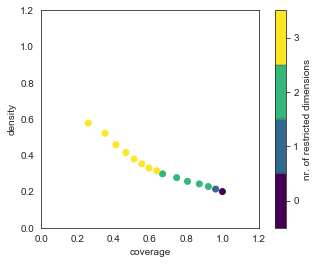

In [11]:
box1.show_tradeoff()
box1.inspect(14)

In [12]:
box2 = prim_alg.find_box()

[MainProcess/INFO] 1820 points remaining, containing 296 cases of interest
[MainProcess/INFO] mean: 0.38311688311688313, mass: 0.077, coverage: 0.1475, density: 0.38311688311688313 restricted_dimensions: 4


In [60]:
box4 = prim_alg.find_box()

[MainProcess/INFO] 1494 points remaining, containing 471 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.75, returning dump box


In [13]:
print (prim_alg.stats_to_dataframe())

coverage   density   mass  res_dim
box 1    0.2600  0.577778  0.090        3
box 2    0.1475  0.383117  0.077        4


In [61]:
box1.select(21)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [ ]:
# boxes = prim_alg.show_boxes()
prim.Prim.show_boxes(prim_alg)
# #visualize
# prim.show_boxes_individually(boxes, results)
# prim.show_boxes_together(boxes, results)
# plt.show()

In [14]:
# CART
from ema_workbench.analysis import cart
cart_alg = cart.CART(x,y_disutil_dam, 0.05)
cart_alg.build_tree()

In [15]:
print (cart_alg.stats_to_dataframe())
print (cart_alg.boxes_to_dataframe())


coverage   density    mass  res dim
box 1   0.400534  1.000000  0.1500        2
box 2   0.109479  0.820000  0.0500        3
box 3   0.098798  0.740000  0.0500        3
box 4   0.030708  0.230000  0.0500        3
box 5   0.040053  0.300000  0.0500        4
box 6   0.049399  0.370000  0.0500        4
box 7   0.056075  0.420000  0.0500        3
box 8   0.066756  0.500000  0.0500        3
box 9   0.026702  0.153846  0.0650        3
box 10  0.022697  0.134921  0.0630        3
box 11  0.013351  0.052910  0.0945        3
box 12  0.001335  0.010000  0.0500        3
box 13  0.000000  0.000000  0.1075        3
box 14  0.034713  0.260000  0.0500        3
box 15  0.049399  0.264286  0.0700        2
                      box 1                      box 2                \
                        min           max          min           max   
miu_period        10.000000     21.500000    10.000000     21.500000   
sr                 0.202820      0.237335     0.237335      0.299304   
periodfullpart  

In [ ]:
## put results in excel
import pandas as pd

outcomes_df = pd.DataFrame(max_outcomes, index = df_index)
experiments_df = pd.DataFrame(experiments)
df_results = pd.concat([outcomes_df, experiments_df], axis=1)
df_results.to_excel("r_100s_10p.xlsx")

In [ ]:
''' 
########################## adapted from EMA workbench Mexican Flu example #################################
Converting the outcome into a dictionary when PRIM returns a TypeError due to unhashable dictionary
prim.prim requires y to be a 1D array, so why are we doing this?

Is there some other way we can use the flu example for scenario discovery?
In the flu example, there is a zero policy already decided through vensim, but here we are trying to find 
the most vulnerable scenarios across a large ensemble of policies through PRIM.
i.e. we use PRIM to get uncertainty + policy subspace which gives undesirable outcomes 
'''
# transform the outcomes to the required format 

y_dict = {}


# get time and remove it from the dict
for key, value in outcomes.items():
    if key == 'Atmospheric Temperature':
        max_temp = np.max(value, axis=1)
        y_dict['max temp'] = max_temp
    else:
        y_dict[key] = value[:, -1]
y_dict



# commenting out because we don't have a time index
        # we want the time at which the maximum occurred
        # the code here is a bit obscure, I don't know why the transpose
        # of value is needed. This however does produce the appropriate results
#         logical = value.T == np.max(value, axis=1)
#         tr['time of max'] = time[logical.T]